<h1>Day 2: Hardware & Algorithms</h1>
<p><b>Workshop for the Computer Engineering Department, University of Tripoli</b></p>
<p><i>Prepared by Abdulmalek Baitulmal with Gemini</i></p>

## 🛠️ Setup: Installing Libraries

This cell will install the necessary libraries for today's session, including **`qiskit-dynamics`** for pulse-level simulation and **`qiskit-ibm-runtime`** for accessing realistic backend models.

**Please run this cell and wait for the installation to complete before proceeding.**

In [2]:
# Install the necessary libraries
!pip install qiskit=='1.4.4' qiskit-aer pylatexenc qiskit-dynamics qiskit-ibm-runtime

print("✅ Installation command executed.")
print("➡️ If you encounter any errors in the following cells, try restarting the kernel first (from the 'Kernel' menu).")


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
✅ Installation command executed.
➡️ If you encounter any errors in the following cells, try restarting the kernel first (from the 'Kernel' menu).


### Core Imports

Now we'll import all the tools we need for this session.

In [3]:
# Core Qiskit components
from qiskit import QuantumCircuit, pulse, transpile
# from qiskit.pulse import Play, DriveChannel, Gaussian
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, Operator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

# Qiskit Dynamics for pulse simulation
from qiskit_dynamics import Solver
from qiskit_dynamics.pulse import InstructionToSignals

# Visualization tools
from qiskit.visualization import plot_histogram, plot_circuit_layout
import matplotlib.pyplot as plt

# Standard library for math
import numpy as np

# Let's check the version to confirm
import qiskit
print(f"Qiskit Version: {qiskit.__version__}")

Qiskit Version: 1.4.4


## Part 1: Hardware Deep Dive

This section explores the physical reality behind our abstract quantum circuits, from the hardware stack down to the microwave pulses that implement gates.

### Hands-On: A Deeper Dive with Qiskit Dynamics

This advanced example shows how to create a schedule for an SX-SY gate sequence using a DRAG pulse (designed to reduce errors) and simulate its effect on a qubit's state over time.

#### Step 1: Create the Pulse Schedule

/var/folders/ys/y0scvyd9775b2m623518p1940000gn/T/ipykernel_96701/2993044315.py:13: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="sx-sy schedule") as sxsy_schedule:
/var/folders/ys/y0scvyd9775b2m623518p1940000gn/T/ipykernel_96701/2993044315.py:14: DeprecationWarning: The class ``qiskit.pulse.channels.Channel`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.play(pulse.Drag(duration, amp, sig / dt, beta), pulse.DriveChannel(0))
/var/folders/ys/y0scvyd9775b2m623518p1940000gn/T/ipykernel_96701/2993044315.py:14: DeprecationWarning: The function ``q

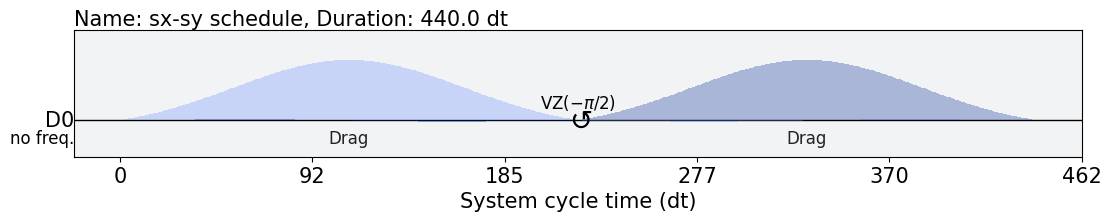

In [4]:
# Define physical parameters
r = 0.1  # Strength of the Rabi-rate in GHz.
w = 5.0  # Frequency of the qubit transition in GHz.
dt = 1 / 4.5  # Sample rate of the backend in ns.

# Define gaussian DRAG pulse parameters
amp = 1. / 1.75
sig = 0.6985 / r / amp
T = 4 * sig
duration = int(T / dt)
beta = 2.0

with pulse.build(name="sx-sy schedule") as sxsy_schedule:
    pulse.play(pulse.Drag(duration, amp, sig / dt, beta), pulse.DriveChannel(0))
    pulse.shift_phase(np.pi/2, pulse.DriveChannel(0))
    pulse.play(pulse.Drag(duration, amp, sig / dt, beta), pulse.DriveChannel(0))

display(sxsy_schedule.draw())

#### Step 2: Convert the Pulse Schedule to a `Signal`

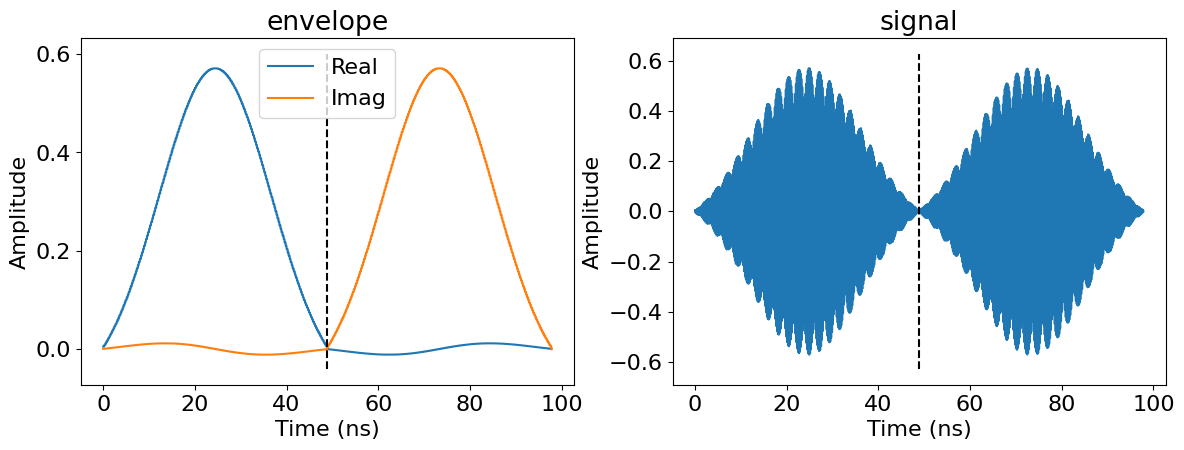

In [5]:
plt.rcParams["font.size"] = 16
converter = InstructionToSignals(dt, carriers={"d0": w})
signals = converter.get_signals(sxsy_schedule)

fig, axs = plt.subplots(1, 2, figsize=(14, 4.5))
for ax, title in zip(axs, ["envelope", "signal"]):
    signals[0].draw(0, 2*T, 2000, title, axis=ax)
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)
    ax.vlines(T, ax.get_ylim()[0], ax.get_ylim()[1], "k", linestyle="dashed")
plt.show()

#### Step 3: Create the System Model

In [6]:
# Construct operators
X = Operator.from_label('X')
Z = Operator.from_label('Z')

drift = 2 * np.pi * w * Z/2
operators = [2 * np.pi * r * X/2]

# Construct the solver
hamiltonian_solver = Solver(
    static_hamiltonian=drift,
    hamiltonian_operators=operators,
    rotating_frame=drift,
    rwa_cutoff_freq=2 * 5.0,
    hamiltonian_channels=['d0'],
    channel_carrier_freqs={'d0': w},
    dt=dt
)

#### Step 4: Simulate the Pulse Schedule and Plot Results

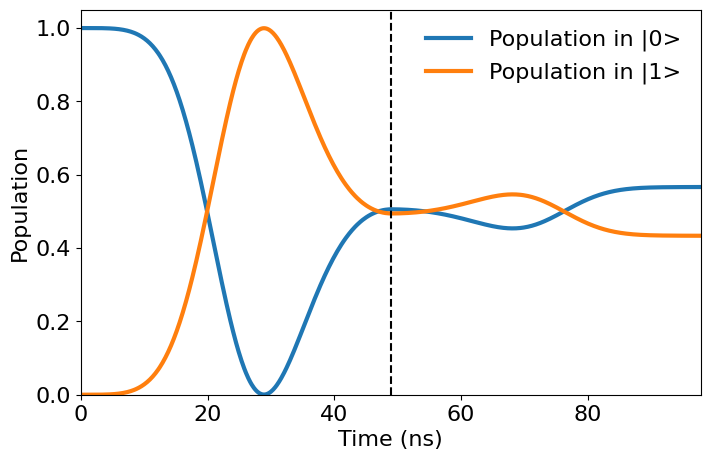

In [7]:
# Start the qubit in its ground state.
y0 = Statevector([1., 0.])

sol = hamiltonian_solver.solve(t_span=[0., 2*T], y0=y0, signals=sxsy_schedule, atol=1e-8, rtol=1e-8)

def plot_populations(sol):
    pop0 = [psi.probabilities()[0] for psi in sol.y]
    pop1 = [psi.probabilities()[1] for psi in sol.y]

    fig = plt.figure(figsize=(8, 5))
    plt.plot(sol.t, pop0, lw=3, label="Population in |0>")
    plt.plot(sol.t, pop1, lw=3, label="Population in |1>")
    plt.xlabel("Time (ns)")
    plt.ylabel("Population")
    plt.legend(frameon=False)
    plt.ylim([0, 1.05])
    plt.xlim([0, 2*T])
    plt.vlines(T, 0, 1.05, "k", linestyle="dashed")
    plt.show()

plot_populations(sol)

---

## Part 2: The Quantum Compiler - An Introduction to Transpilation

The circuits we design are abstract. Real quantum hardware has physical constraints, such as limited qubit connectivity and a small set of native gates. **Transpilation** is the process of compiling our ideal circuit into one that can actually run on a specific quantum device.

### Hands-On: Visualizing SWAP Gate Insertion

Let's see what happens when we try to run a circuit with a CNOT gate between two qubits that are not physically connected. The transpiler must insert SWAP gates to make this possible.

Original Circuit (Impossible on Hardware):


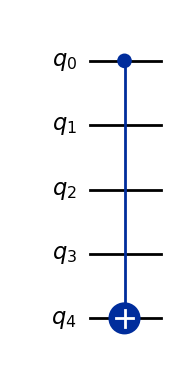


Transpiled Circuit (Runnable on Hardware):


/Users/abdulmalekbaitulmal/Downloads/Desktop/Quanta Related/QC for EC/QC for EC - Notebooks/.venv/lib/python3.12/site-packages/qiskit_ibm_provider/api/session.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


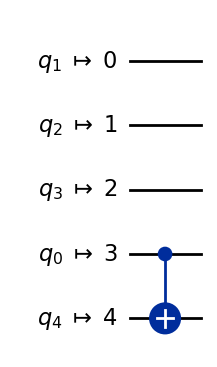

Notice how the transpiler added SWAP gates to move the qubit states next to each other!


In [8]:
# Load a fake backend that mimics a real 5-qubit machine
backend = FakeManilaV2()

# Create a circuit with a CNOT between non-adjacent qubits (0 and 4)
qc_original = QuantumCircuit(5)
qc_original.cx(0, 4)

print("Original Circuit (Impossible on Hardware):")
display(qc_original.draw('mpl'))

# Transpile the circuit for the hardware backend
qc_transpiled = transpile(qc_original, backend)

print("\nTranspiled Circuit (Runnable on Hardware):")
display(qc_transpiled.draw('mpl'))
print("Notice how the transpiler added SWAP gates to move the qubit states next to each other!")

---

## Part 3: From Hardware to Algorithms (FFT vs. QFT)

Now, let's build the Quantum Fourier Transform from scratch to understand its structure, and then simulate it.

### Step 1: The Classical FFT Demo

First, a reminder of what a classical Fourier Transform does: it's a **frequency analyzer** that finds the constituent frequencies in a signal.

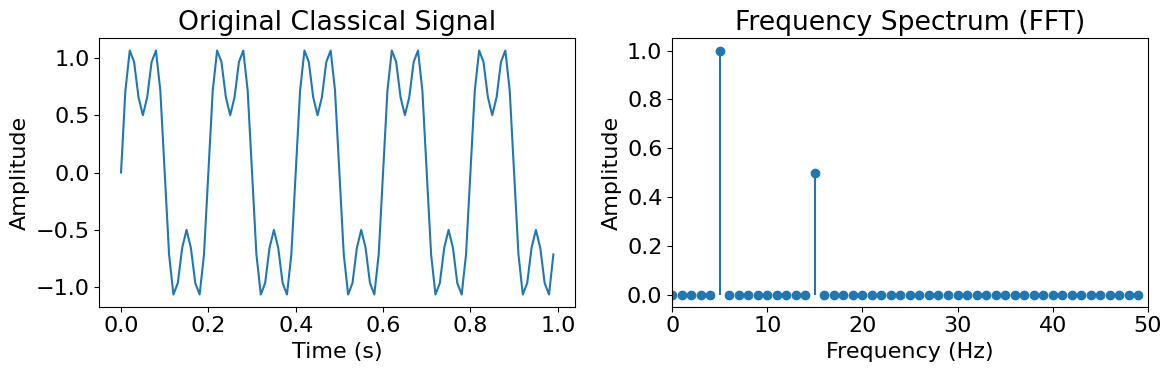

In [9]:
# Create a classical signal that's a mix of two frequencies: 5 Hz and 15 Hz
sampling_rate = 100
duration = 1
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
signal = np.sin(2 * np.pi * 5 * t) + 0.5 * np.sin(2 * np.pi * 15 * t)

# Perform the FFT and plot the results
fft_output = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(signal), d=1/sampling_rate)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(t, signal)
ax1.set_title('Original Classical Signal')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')
ax2.stem(frequencies, np.abs(fft_output) / len(signal) * 2, basefmt=" ")
ax2.set_title('Frequency Spectrum (FFT)')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')
ax2.set_xlim(0, sampling_rate / 2)
plt.tight_layout()
plt.show()

### Step 2: Hands-On with the Quantum Fourier Transform

Here we will build the QFT from scratch using basic gates and then apply it to an initial state.

5-Qubit Quantum Fourier Transform (QFT) Circuit Diagram:


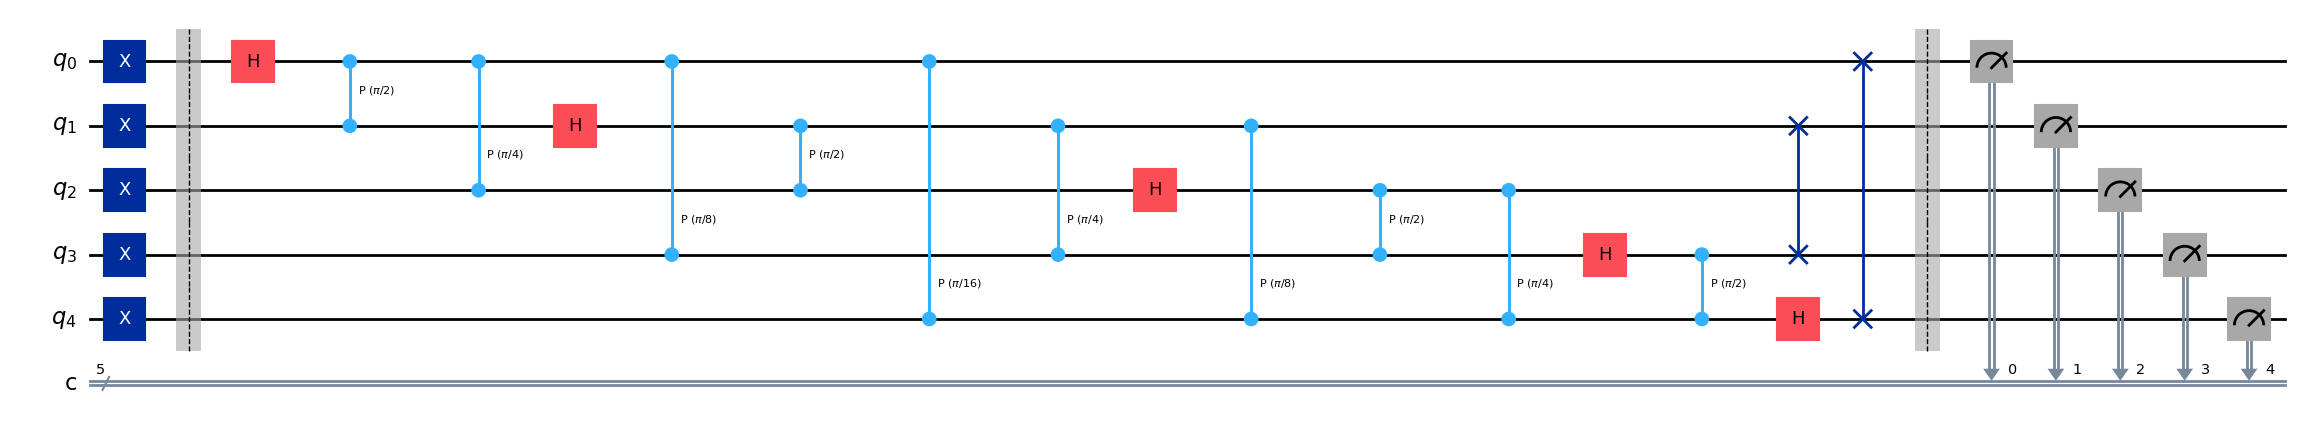


Measurement Counts for initial state |11111>:


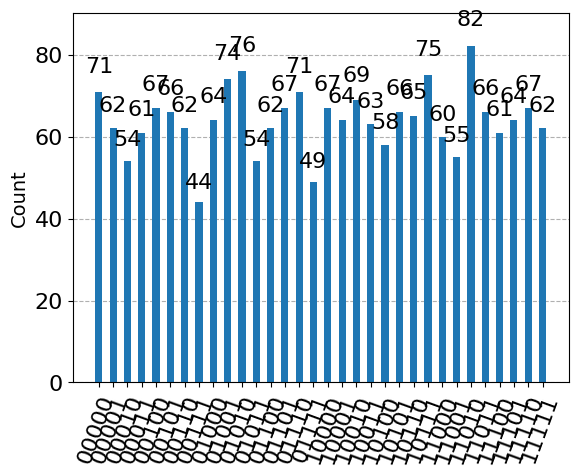

In [10]:
def qft_circuit(qc, n_qubits):
    """Builds a QFT circuit from scratch on the given QuantumCircuit object."""
    for i in range(n_qubits):
        qc.h(i)
        for j in range(i + 1, n_qubits):
            qc.cp(np.pi / (2**(j - i)), i, j) # Apply controlled phase rotations
    
    for i in range(n_qubits // 2):
        qc.swap(i, n_qubits - 1 - i)

# Set the number of qubits
num_qft_qubits = 5 

# Create a quantum circuit
qc_qft = QuantumCircuit(num_qft_qubits, num_qft_qubits)

# Prepare an initial state (e.g., |11111>)
for i in range(num_qft_qubits):
    qc_qft.x(i)

qc_qft.barrier() # Visual separator

# Apply the QFT transformation
qft_circuit(qc_qft, num_qft_qubits)

qc_qft.barrier() # Visual separator

# Measure all qubits
qc_qft.measure(range(num_qft_qubits), range(num_qft_qubits))

# Draw the QFT circuit
print(f"{num_qft_qubits}-Qubit Quantum Fourier Transform (QFT) Circuit Diagram:")
display(qc_qft.draw(output="mpl", fold=-1))

# Select the Aer simulator backend
simulator = AerSimulator()

# Execute the circuit
job = simulator.run(qc_qft, shots=2048)
result = job.result()
counts = result.get_counts(qc_qft)

print(f"\nMeasurement Counts for initial state |11111>:")
display(plot_histogram(counts))

## End of Day 2

Today we went on a journey from the physical hardware that runs quantum computations, through the crucial 'compiler' step of transpilation, and finally applied it to a foundational quantum algorithm. You are now well-equipped to understand the full stack of quantum computing. Tomorrow, we'll explore the impact of these capabilities on AI and security.